# 4 Task A: Individual Neural Networks for Each Forecast Horizon

## 4.1 Data Preparation

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import joblib
import random
import matplotlib.pyplot as plt
import torch.nn as nn

### (a) Load the data from Nino3.4 data.csv

In [2]:
data = pd.read_csv("Nino3.4_data.csv")

### (b) Read test years from test years.csv. Extract all data rows from step (a) that match these test years to create your test set. This test data must remain untouched during training. You should use this test set to evaluate your model’s performance and report results

In [3]:
test_years = pd.read_csv("test_years.csv")["year"].tolist()

### (c) Subset your test data based on the test years, then randomly partition the remainingdataset into training and validation sets. Choose an appropriate split ratio that ensures sufficient data for both training and validation.

In [4]:
test_data = data[data["year"].isin(test_years)].reset_index(drop=True)
train_val_data = data[~data["year"].isin(test_years)].reset_index(drop=True)

# 在剩余数据中随机划分训练集与验证集
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42, shuffle=True)

### (d) Pre-processing: Apply scaling transformations to the input features (nino tminus2, nino tminus1, nino t). Scaling the target variables (nino tplus1 through nino tplus6) is optional - if you choose to scale them, save the target scalers for inverse transformation during evaluation. Apply the same transformations to the validation set.

Optional: You might also consider creating additional features from the month column. For example, some students find it helpful to encode the cyclical nature of months using sine and cosine transformations: sin(2π × month/12) and cos(2π × month/12). This can help the model understand that December is adjacent to January.

Note: Save your scaler objects for later use (e.g., using pickle or joblib).

In [9]:
# 输入特征与目标列
input_features = ["nino_tminus2", "nino_tminus1", "nino_t"]
target_features = ["nino_tplus1", "nino_tplus2", "nino_tplus3", "nino_tplus4", "nino_tplus5", "nino_tplus6"]

# 可选：添加月份的正弦余弦特征
for df in [train_data, val_data, test_data]:
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # 将它们加入输入特征中
    df.reset_index(drop=True, inplace=True)

input_features_extended = input_features + ["month_sin", "month_cos"]

# 缩放输入特征
scaler_X = StandardScaler()
train_X_scaled = scaler_X.fit_transform(train_data[input_features_extended])
val_X_scaled = scaler_X.transform(val_data[input_features_extended])
test_X_scaled = scaler_X.transform(test_data[input_features_extended])

# 可选：缩放目标变量
scale_targets = True  # ← 如果不希望缩放，改成 False
if scale_targets:
    scaler_y = StandardScaler()
    train_y_scaled = scaler_y.fit_transform(train_data[target_features])
    val_y_scaled = scaler_y.transform(val_data[target_features])
    test_y_scaled = scaler_y.transform(test_data[target_features])
else:
    train_y_scaled = train_data[target_features].values
    val_y_scaled = val_data[target_features].values
    test_y_scaled = test_data[target_features].values
    scaler_y = None

# 保存缩放器以供后续反缩放或预测使用
joblib.dump(scaler_X, "scaler_X.pkl")
if scaler_y:
    joblib.dump(scaler_y, "scaler_y.pkl")

# ---------- 转换为 PyTorch 张量 ----------
train_X = torch.tensor(train_X_scaled, dtype=torch.float32)
val_X = torch.tensor(val_X_scaled, dtype=torch.float32)
test_X = torch.tensor(test_X_scaled, dtype=torch.float32)

train_y = torch.tensor(train_y_scaled, dtype=torch.float32)
val_y = torch.tensor(val_y_scaled, dtype=torch.float32)
test_y = torch.tensor(test_y_scaled, dtype=torch.float32)

# ---------- 创建 TensorDataset ----------
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

# 示例：构建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 584
Val size: 146
Test size: 72


### (e) Train a neural network that predicts the Ni˜no3.4 index of the next month, i.e.nino tplus1 using reasonable hyperparameters. Ensure reproducibility by setting a seed throughout your code. Plot the training and validation loss curves across epochs.
Note: Save your trained models in a format appropriate for your chosen framework. Common formats include .keras, .h5, .pth, .pt, or .onnx. Ensure your models can be loaded during evaluation

Epoch [10/100] | Train Loss: 0.110973 | Val Loss: 0.099633
Epoch [20/100] | Train Loss: 0.091432 | Val Loss: 0.087669
Epoch [30/100] | Train Loss: 0.089785 | Val Loss: 0.083977
Epoch [40/100] | Train Loss: 0.081442 | Val Loss: 0.084006
Epoch [50/100] | Train Loss: 0.078977 | Val Loss: 0.085558
Epoch [60/100] | Train Loss: 0.078705 | Val Loss: 0.085200
Epoch [70/100] | Train Loss: 0.073643 | Val Loss: 0.087020
Epoch [80/100] | Train Loss: 0.078852 | Val Loss: 0.084263
Epoch [90/100] | Train Loss: 0.066640 | Val Loss: 0.082509
Epoch [100/100] | Train Loss: 0.070873 | Val Loss: 0.081227


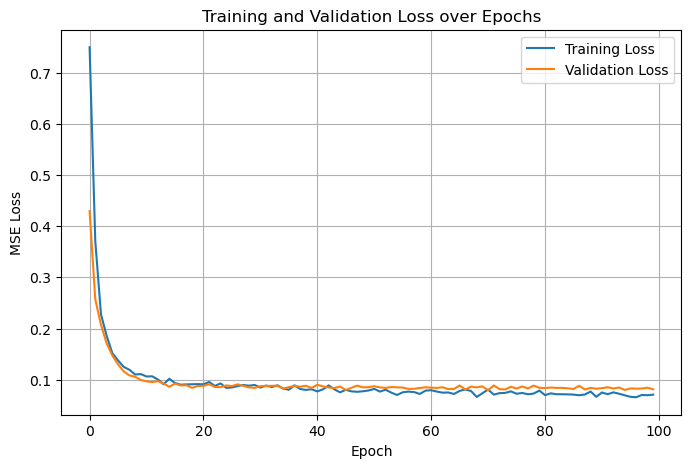

模型已保存为 nino_model_next_month.pth


In [11]:
# ---------- 设置随机种子以确保可复现性 ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 如果有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 只使用目标 nino tplus1 ----------
train_y1 = train_y[:, 0].unsqueeze(1)  # (N, 1)
val_y1 = val_y[:, 0].unsqueeze(1)

train_dataset_1 = torch.utils.data.TensorDataset(train_X, train_y1)
val_dataset_1 = torch.utils.data.TensorDataset(val_X, val_y1)

train_loader = torch.utils.data.DataLoader(train_dataset_1, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset_1, batch_size=32, shuffle=False)

# ---------- 定义神经网络 ----------
class NinoNet(nn.Module):
    def __init__(self, input_dim):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = train_X.shape[1]
model = NinoNet(input_dim).to(device)

# ---------- 定义损失函数和优化器 ----------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# ---------- 训练循环 ----------
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # 训练模式
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * X_batch.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)

    # 验证模式
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item() * X_batch.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

# ---------- 绘制训练与验证损失曲线 ----------
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 保存模型 ----------
torch.save(model.state_dict(), "nino_model_next_month.pth")
print("模型已保存为 nino_model_next_month.pth")

### (f) Repeat (e) for the subsequent months, i.e., nino_tplus2, nino_tplus3,.. nino_tplus6. Together with part (e), this will give you six trained networks and six plots for training and validation loss, shown in one Figure

In [ ]:
# ---------- 训练函数 ----------
def train_single_horizon(horizon_index, epochs=100, lr=1e-3, batch_size=32):
    # 目标列索引
    y_train_h = train_y[:, horizon_index].unsqueeze(1)
    y_val_h = val_y[:, horizon_index].unsqueeze(1)

    # 数据加载
    train_dataset = TensorDataset(train_X, y_train_h)
    val_dataset = TensorDataset(val_X, y_val_h)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 模型定义
    model = NinoNet(train_X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    # 记录损失
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * Xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                total_val_loss += loss.item() * Xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    # 绘图
    plt.figure(figsize=(4,3))
    plt.plot(train_losses, label="Training Loss", color="steelblue")
    plt.plot(val_losses, label="Validation Loss", color="orchid")
    plt.xlabel("Training Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f"Horizon: {horizon_index+1} Month")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()